# Functional Data Analysis with Monovariate Prediction
This notebook demonstrates the process of conducting a functional data analysis with a focus on monovariate prediction. It outlines the goal of the notebook, the dataset being used, and the main steps that will be taken.

## Setting Up the Environment
The following cells set up the environment by loading necessary libraries and defining the path to the simulation file.

In [2]:
# @__DIR__ is the directory of the current file
# We need to go up to the parent directory to find the project root
project_root = dirname(dirname(@__DIR__))


include(joinpath(project_root, "setup", "init_env.jl"))
set_R_lib_path(project_root)

  Activating project at `c:\Users\User\Documents\repos\TESI\tesi_data\progetto_s_on_f.md\b_spline\functional-data-regression-mip`


RObject{StrSxp}
[1] "C:/Users/User/AppData/Local/R/cache/R/renv/library/functional-data-regression-mip-e3349204/R-4.3/x86_64-w64-mingw32"
[2] "C:/Users/User/AppData/Local/R/win-library/4.3"                                                                      
[3] "C:/Program Files/R/R-4.3.1/library"                                                                                 


## Load Data and Run R Simulation
Here we load the data required for the simulation and run the R simulation script to prepare the data for analysis.

**NOTICE** -> The seed should be the same for both the training and the test datasets, otherwise the data distribution will be different. 
This is very important specifically in the "Paper simulation" where the predictors shape depends on the coefficients a1,...f3 extracted from Uniform and Normal distributions.  

In [1]:
simulation_name = "paper"
simulation_settings_file = "default"
predictors= 6
basis_functions = 6
measurements = 150
observations_train = 300
observations_test = 100
phi = 10^-4
lambda = 10^-6

BigM = ones(predictors) .*  1000.0
BigM_ =  ones(predictors) .* - 1000.0;


In [2]:
include(joinpath(project_root, "src", "Julia", "utils", "simulation.jl"))

params_train = (
    observations = 200,
    measurements = measurements,
    basis_functions = basis_functions,
    seed = 1,
    phi = phi
)

params_test = (
    observations = 200,
    measurements = measurements,
    basis_functions = basis_functions,
    seed = 22,
    phi = phi
)

# Note: Use ... to unpack NamedTuple into keyword arguments
output = load_simulation_gertheiss(simulation_name, simulation_settings_file, project_root; params_train...)

output_test = load_simulation_gertheiss(simulation_name, simulation_settings_file, project_root; params_test...)


# Grab the outputs from the R script

predictors = Int(output[:predictors])
true_predictors = output[:true_predictors]
intercept = output[:intercept]
observations = Int(output[:observations])

# betas and basis
beta_matrix  = output[:B]
basis_objs   = output[:basis_objs]
basis_values = output[:basis_values]
time_domains = output[:time_domains]

# matrixes 
U = output[:U]
X = output[:X]
Y = output[:Y]
Z = output[:Z]
J = output[:J]
W = output[:W]


X_test = output_test[:X]
Y_test = output_test[:Y]
Z_test = output_test[:Z]
J_test = output_test[:J]
W_test = output_test[:W]



# remove the first element of each row of Z
Z = Z[:, 2:end]

Z_reshaped = zeros(observations, predictors, basis_functions)
# For each observation
for i in 1:observations
  # For each predictor
  for j in 1:predictors
    # Assign the corresponding elements from Z to Z_reshaped
    # Skip the first element in each row by adding 1 to the start and end indices
    start_index = (j - 1) * basis_functions + 1
    end_index = min(j * basis_functions, length(Z[i,:]))
    Z_reshaped[i, j, :] = Z[i, start_index:end_index]
  end
end
Z = Z_reshaped

LoadError: UndefVarError: `project_root` not defined

In [3]:
model_name = "l0_gertheiss"
model_file_path = joinpath(project_root, "src", "Julia","models", model_name *".jl")

include(model_file_path)

beta_matrix_max_values = maximum(beta_matrix, dims = 2)
beta_matrix_min_values = minimum(beta_matrix, dims = 2)


# create a zero matrix from beta_star dimensions
initial_betas = beta_matrix
to_predict = sum(true_predictors)
beta_star, alpha_star, groups = mip_functional_regression(Y, Z, BigM,BigM_; intercept = output[:intercept] != 0, group_limit= to_predict, initial_beta = initial_betas,initial_group=to_predict,lambda);

project_root = dirname( dirname(@__DIR__))
plot_file_path = joinpath(project_root, "src", "Julia","utils", "plot.jl")

include(plot_file_path)

output_folder= joinpath(project_root, "outputs", "plots", simulation_name)

beta_point_values = output[:beta_point_values]





LoadError: UndefVarError: `project_root` not defined

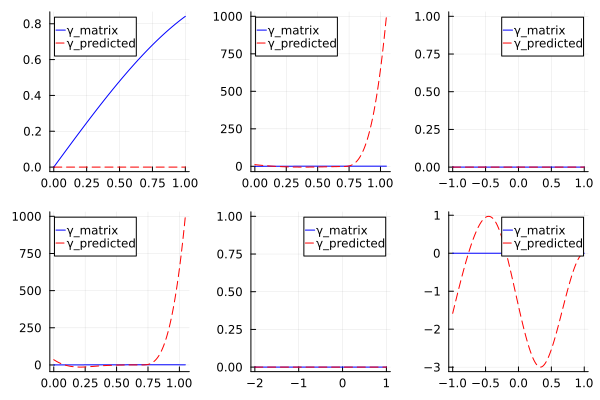

"c:\\Users\\User\\Documents\\repos\\TESI\\tesi_data\\progetto_s_on_f.md\\b_spline\\functional-data-regression-mip\\outputs\\plots\\paper\\combined.png"

In [339]:
plot_combined_predicted_curve(beta_point_values, beta_star,basis_values, time_domains,output_folder, true)

In [340]:
beta_matrix

6×6 Matrix{Float64}:
 5.30582e-6   0.1111    0.333325  0.629925  0.781476  0.841466
 0.000186225  0.232358  0.69762   1.06815   0.98308   0.865984
 0.0          0.0       0.0       0.0       0.0       0.0
 0.000186225  0.232358  0.69762   1.06815   0.98308   0.865984
 0.0          0.0       0.0       0.0       0.0       0.0
 0.0          0.0       0.0       0.0       0.0       0.0

In [341]:
beta_star

6×6 Matrix{Float64}:
  0.0       0.0      0.0       0.0       0.0     0.0
 11.1279    0.0     -8.96194   0.0       0.0  1000.0
  0.0       0.0      0.0       0.0       0.0     0.0
 35.3493  -30.0491   0.0       0.309534  0.0  1000.0
  0.0       0.0      0.0       0.0       0.0     0.0
 -1.5829    0.0      3.04735  -6.01138   0.0     0.0

In [342]:
using Statistics 
using LinearAlgebra

include(joinpath(project_root, "src", "Julia", "utils", "data_analysis.jl"))

performance_metrics = compute_metrics(Y, Z, beta_matrix, beta_matrix, alpha_star, groups, predictors)


Dict{String, Float64} with 11 entries:
  "Functional_Correlation" => 0.949032
  "CDF_Distance"           => 0.380608
  "R_squared"              => 0.747173
  "RMSE_Predictions"       => 0.738197
  "RMSE_Coefficients"      => 0.0
  "Area_Between_Curves"    => 118.135
  "ISE_Coefficients"       => 0.0
  "MSE_Predictions"        => 0.544935
  "Adjusted_R_squared"     => 0.749367
  "MSE_Coefficients"       => 0.0
  "MAE_Predictions"        => 0.590675

In [343]:
performance_metrics = compute_metrics(Y, Z, beta_matrix, beta_star, alpha_star, groups, predictors)


Dict{String, Float64} with 11 entries:
  "Functional_Correlation" => 0.853887
  "CDF_Distance"           => 0.233924
  "R_squared"              => 0.716665
  "RMSE_Predictions"       => 0.781467
  "RMSE_Coefficients"      => 235.642
  "Area_Between_Curves"    => 128.837
  "ISE_Coefficients"       => 1.99898e6
  "MSE_Predictions"        => 0.610691
  "Adjusted_R_squared"     => 0.707995
  "MSE_Coefficients"       => 55527.1
  "MAE_Predictions"        => 0.644187

## Execute

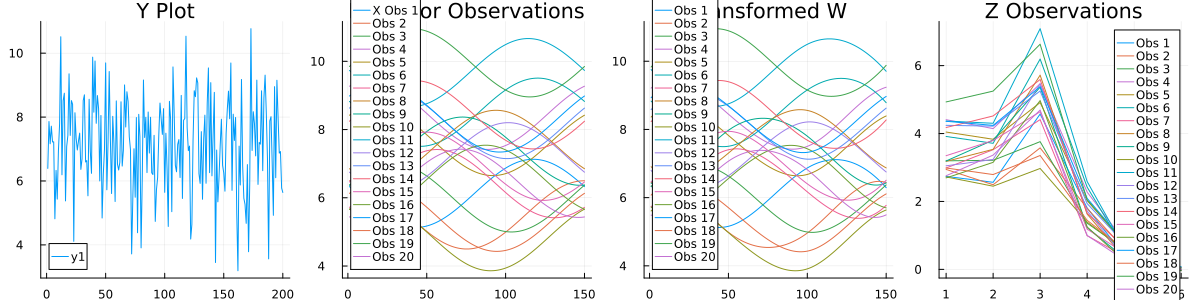

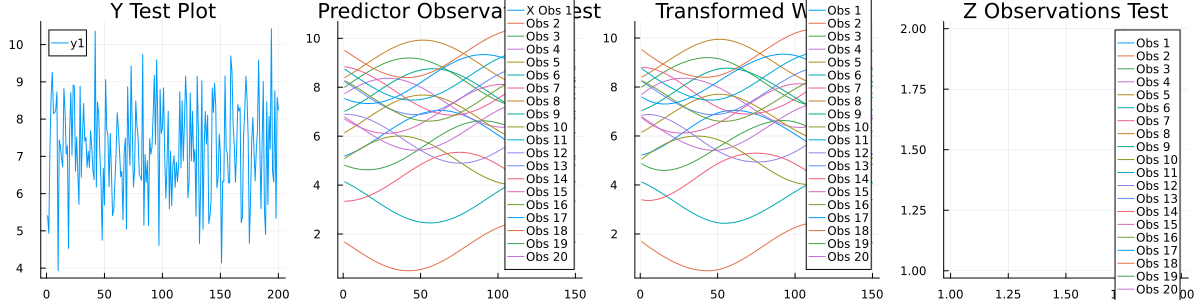

In [344]:
# Function to plot multiple observations for a single predictor
function plot_predictor_observations(X, predictor, obs, plot_title)
    p = plot(X[1, predictor, :], label = "X Obs 1", title = plot_title)  # Start with the first observation
    for i in 2:obs
        plot!(p, X[i, predictor, :], label = "Obs $i")  # Add the rest
    end
    return p
end

# Function to plot the W matrix transformed by the basis values
function plot_transformed_W(basis_values, W, predictor, obs, plot_title)
    p = plot(basis_values[predictor,:,:] * W[1, predictor, :], label = "Obs 1", title = plot_title)  # Start with the first observation
    for i in 2:obs
        plot!(p, basis_values[predictor,:,:] * W[i, predictor, :], label = "Obs $i")  # Add the rest
    end
    return p
end

# Function to plot Z for multiple observations
function plot_Z_observations(Z, predictor, obs, plot_title)
    p = plot(Z[1, predictor, :], label = "Obs 1", title = plot_title)  # Start with the first observation
    for i in 2:obs
        plot!(p,  Z[i, predictor, :], label = "Obs $i")  # Add the rest
    end
    return p
end

# Initialize the plot for predictors
predictor = 1
obs = 20  # Limiting to the first 20 observations for clarity

# Plot Y and Y_test
pY = plot(Y, title = "Y Plot")
pY_test = plot(Y_test, title = "Y Test Plot")

# Plot the predictor, transformed W, and Z for both non-test and test data
p1 = plot_predictor_observations(X, predictor, obs, "Predictor Observations")
p2 = plot_transformed_W(basis_values, W, predictor, obs, "Transformed W")
p3 = plot_Z_observations(Z, predictor, obs, "Z Observations")

p11 = plot_predictor_observations(X_test, predictor, obs, "Predictor Observations Test")
p22 = plot_transformed_W(basis_values, W_test, predictor, obs, "Transformed W Test")
p33 = plot_Z_observations(Z_test, predictor, obs, "Z Observations Test")

# Combining plots side by side
p_non_test = plot(pY, p1, p2, p3, layout = (1, 4), size = (1200, 300))
p_test = plot(pY_test, p11, p22, p33, layout = (1, 4), size = (1200, 300))

# Displaying the combined plots
display(p_non_test)
display(p_test)

## Evaluate Model Performance
Evaluate the model's performance using various metrics such as MSE, RMSE, MAE, and relative error.

## Prediction and Evaluation (FIX ME <-- compute real intervals)
Make predictions using the estimated coefficients and evaluate the model's accuracy.

In [345]:
using Statistics

# Evaluation of all metrics in the performance dictionary
function evaluate_all_metrics(performances, thresholds, higher_is_better)
    evaluations = Dict{String, String}()
    for (generic_name, metric_value) in performances
        if haskey(thresholds, generic_name)
            good_threshold, excellent_threshold = thresholds[generic_name]
            is_higher_better = get(higher_is_better, generic_name, false)
            evaluations[generic_name] = valuate_metric(metric_value, good_threshold, excellent_threshold, is_higher_better)
        end
    end
    return evaluations
end

# Method to evaluate a single metric
function valuate_metric(metric_value, good_threshold, excellent_threshold=nothing, higher_is_better=false)
    if isnothing(excellent_threshold)
        # Only a good threshold is provided
        if higher_is_better
            return metric_value >= good_threshold ? "Good" : "Poor"
        else
            return metric_value <= good_threshold ? "Good" : "Poor"
        end
    else
        # Both good and excellent thresholds are provided
        if higher_is_better
            if metric_value >= excellent_threshold
                return "Excellent"
            elseif metric_value >= good_threshold
                return "Good"
            else
                return "Poor"
            end
        else
            if metric_value <= excellent_threshold
                return "Excellent"
            elseif metric_value <= good_threshold
                return "Good"
            else
                return "Poor"
            end
        end
    end
end


# Define if higher values are better for each metric
higher_is_better = Dict(
    "MSE_Coefficients"       => false,
    "RMSE_Coefficients"      => false,
    "ISE_Coefficients"       => false,
    "MSE_Predictions"        => false,
    "RMSE_Predictions"       => false,
    "MAE_Predictions"        => false,
    "R_squared"              => true,
    "Adjusted_R_squared"     => true,
    "Functional_Correlation" => true,
    "CDF_Distance"           => false,
    "Area_Between_Curves"    => false
);




In [346]:
# Compute descriptive statistics for an array
function compute_stats(data)
    return Dict(
        "mean" => mean(data),
        "std" => std(data),
        "min" => minimum(data),
        "max" => maximum(data),
        "iqr" => quantile(data, 0.75) - quantile(data, 0.25)
    )
end

# Determine scaling thresholds based on the computed statistics
function determine_scaling_thresholds(beta_stats, prediction_stats)
    # Error-based metrics: Set thresholds based on standard deviation or IQR
    scaling_thresholds = Dict(
        "MSE_Coefficients" => (beta_stats["std"], beta_stats["std"] / 2),
        "RMSE_Coefficients" => (sqrt(beta_stats["std"]), sqrt(beta_stats["std"] / 2)),
        "ISE_Coefficients" => (beta_stats["iqr"], beta_stats["iqr"] / 2),
        "MSE_Predictions" => (prediction_stats["std"], prediction_stats["std"] / 2),
        "RMSE_Predictions" => (sqrt(prediction_stats["std"]), sqrt(prediction_stats["std"] / 2)),
        "MAE_Predictions" => (prediction_stats["iqr"], prediction_stats["iqr"] / 2),
        "R_squared" => (0.5, 0.7),  # Static thresholds
        "Adjusted_R_squared" => (0.5, 0.7),  # Static thresholds
        "Functional_Correlation" => (0.3, 0.5),  # Got to figure out what to use here
        "CDF_Distance" => (prediction_stats["iqr"], prediction_stats["iqr"] / 2),  # ????
        "Area_Between_Curves" => (prediction_stats["iqr"], prediction_stats["iqr"] / 2)  # ???
    )
    return scaling_thresholds
end

# Assuming you have computed your beta_matrix, beta_star, and predictions
# Compute stats for beta coefficients and predictions
beta_stats = compute_stats(reshape(beta_matrix, :))
prediction_stats = compute_stats(reshape(Y_test, :))  # Assuming Y_test contains predictions

# Determine scaling thresholds
scaling_thresholds = determine_scaling_thresholds(beta_stats, prediction_stats)

# Print thresholds
print("Scaling Thresholds: ", scaling_thresholds)


Scaling Thresholds: Dict("Functional_Correlation" => (0.3, 0.5), "CDF_Distance" => (1.8767456068239543, 0.9383728034119772), "R_squared" => (0.5, 0.7), "RMSE_Predictions" => (1.1337586690888077, 0.8016884431417309), "RMSE_Coefficients" => (0.6334453558644626, 0.4479135066428873), "Area_Between_Curves" => (1.8767456068239543, 0.9383728034119772), "ISE_Coefficients" => (0.6976202183562085, 0.34881010917810423), "MSE_Predictions" => (1.2854087197340247, 0.6427043598670124), "Adjusted_R_squared" => (0.5, 0.7), "MSE_Coefficients" => (0.4012530188662557, 0.20062650943312785), "MAE_Predictions" => (1.8767456068239543, 0.9383728034119772))

In [347]:
# Perform evaluations
evaluations = evaluate_all_metrics(performance_metrics, scaling_thresholds, higher_is_better)

# Display evaluations
for (metric, evaluation) in evaluations
    metric_value = performance_metrics[metric]
    metric_range = scaling_thresholds[metric]
    println("$metric: $evaluation, Value: $metric_value, Range: $metric_range")
end

Functional_Correlation: Excellent, Value: 0.8538868488625142, Range: (0.3, 0.5)
CDF_Distance: Excellent, Value: 0.23392443176411248, Range: (1.8767456068239543, 0.9383728034119772)
RMSE_Predictions: Excellent, Value: 0.7814672125478082, Range: (1.1337586690888077, 0.8016884431417309)
RMSE_Coefficients: Poor, Value: 235.64186447315024, Range: (0.6334453558644626, 0.4479135066428873)
Area_Between_Curves: Poor, Value: 128.83742806284812, Range: (1.8767456068239543, 0.9383728034119772)
ISE_Coefficients: Poor, Value: 1.9989751785257699e6, Range: (0.6976202183562085, 0.34881010917810423)
Adjusted_R_squared: Excellent, Value: 0.707995190589958, Range: (0.5, 0.7)
MAE_Predictions: Excellent, Value: 0.6441871403142406, Range: (1.8767456068239543, 0.9383728034119772)
R_squared: Excellent, Value: 0.7166646659999307, Range: (0.5, 0.7)
MSE_Predictions: Excellent, Value: 0.6106910042872411, Range: (1.2854087197340247, 0.6427043598670124)
MSE_Coefficients: Poor, Value: 55527.0882923825, Range: (0.4012

## Residual Analysis
Analyze the residuals from the model to check for any patterns that might suggest issues with the model.

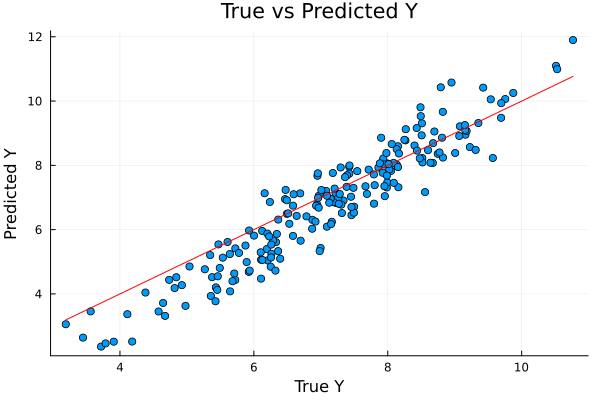

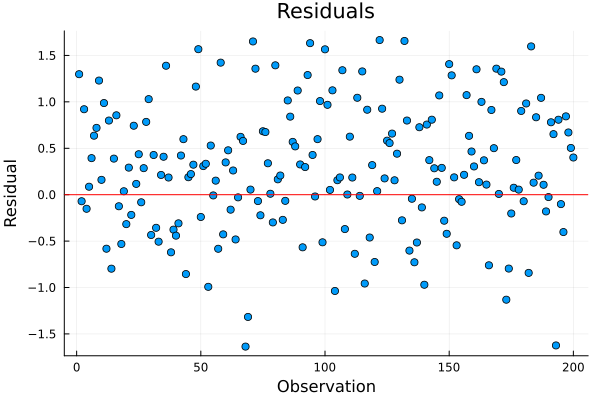

In [348]:
using Plots

Y_pred = get_predictions(Z, beta_matrix, alpha_star)
# 1. Scatter plot comparing true vs predicted values
scatter(Y, Y_pred, xlabel="True Y", ylabel="Predicted Y", legend=false, title="True vs Predicted Y")
plot!(Y, Y, color=:red)  # A y=x line for reference
display(plot!())

# 2. Plot residuals
residuals = Y - Y_pred
scatter(1:observations, residuals, xlabel="Observation", ylabel="Residual", legend=false, title="Residuals")
hline!([0], color=:red, label="Zero line")
display(plot!())


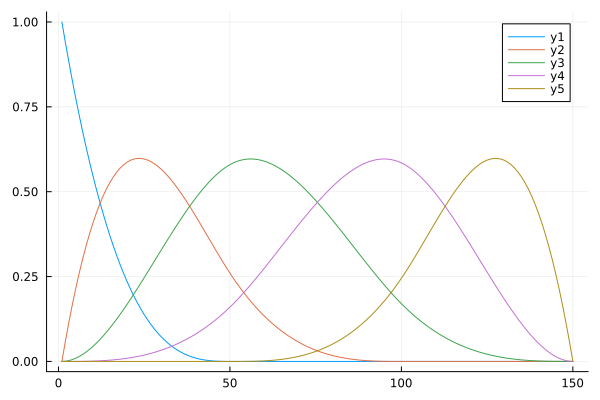

In [349]:
pbasis_values =basis_values
plot( pbasis_values[1,:,1])
plot!(pbasis_values[1,:,2])
plot!(pbasis_values[1,:,3])
plot!(pbasis_values[1,:,4])
plot!(pbasis_values[1,:,5])


## Final Output
Plot the combined predicted curve and save the output for further analysis.

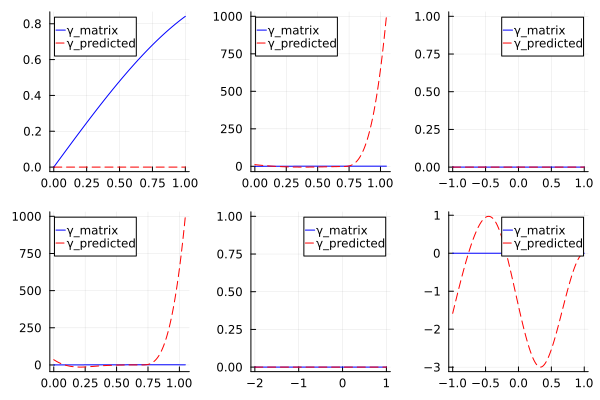

"c:\\Users\\User\\Documents\\repos\\TESI\\tesi_data\\progetto_s_on_f.md\\b_spline\\functional-data-regression-mip\\outputs\\plots\\paper\\combined.png"

In [350]:
project_root = dirname( dirname(@__DIR__))
plot_file_path = joinpath(project_root, "src", "Julia","utils", "plot.jl")

include(plot_file_path)

output_folder= joinpath(project_root, "outputs", "plots", simulation_name)

beta_point_values = output[:beta_point_values]
plot_combined_predicted_curve(beta_point_values, beta_star,basis_values, time_domains,output_folder, true)


In [351]:
# beta_matrix = output[:B]
# predictor = 4
# y =basis_values[predictor,:,:] * beta_matrix[predictor,:];

# plot(time_domains[predictor], y, label="APPROX")
# # apply the sin(t) function to all the elements in time_domains[1,:]
# y2 = Array{Float64}(undef, size(y))
# for i in 1:length(y)
#     y2[i] = sinccoutput[:beta_funcs]()
# end
# # plot the line y = sin(t) on the same plot
# plot!(time_domains[predictor], y2, label="TRUE")
# display(plot!())
